# SELFLEARNING: HuggingFace Image Generation

In [ ]:
!pip install diffusers accelerate --quiet

# Unconditional Image Generation

Unconditional image generation is the task of generating images with no condition in any context (like a prompt text or another image). Once trained, the model will create images that resemble its training data distribution.

Unconditional image generation models usually start with a seed that generates a random noise vector. The model will then use this vector to create an output image similar to the images used for training the model.


#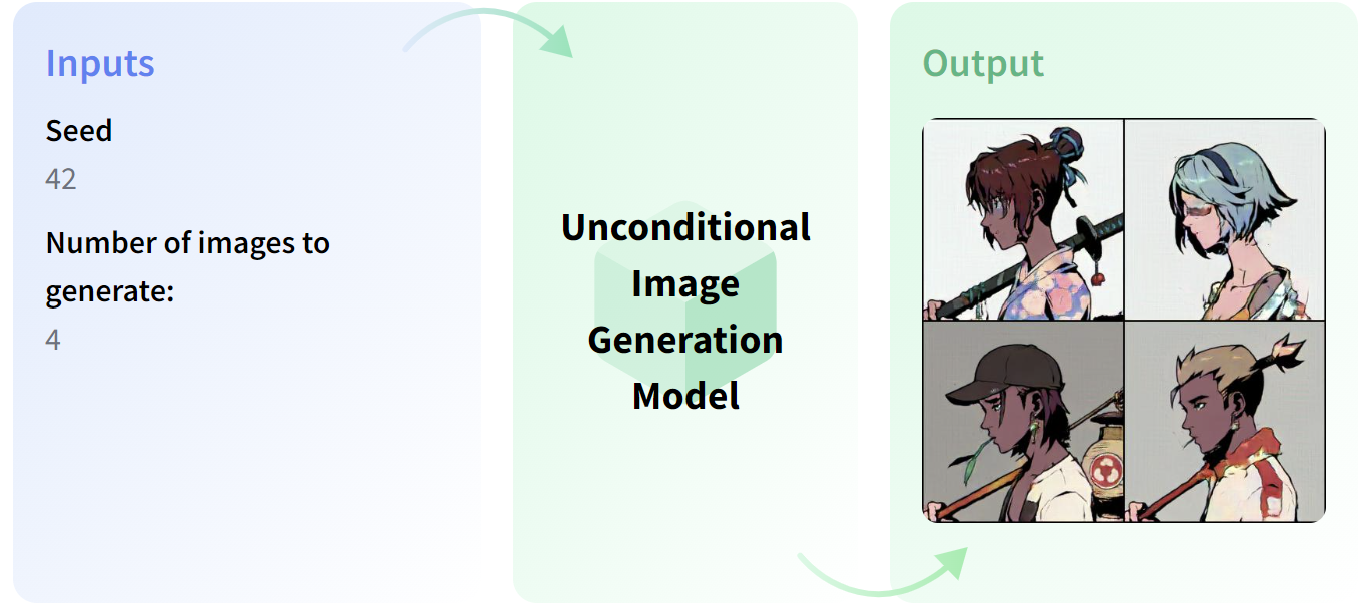


In [ ]:
# Import the DiffusionPipeline class from the diffusers library.
from diffusers import DiffusionPipeline

# Initialize a generator object by loading a pre-trained model "anton-l/ddpm-butterflies-128"
# from a model repository. This model is  trained to generate images of butterflies.
generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128")

# Move the generator to a CUDA device for GPU acceleration, which speeds up the computation.
generator.to("cuda")

# Generate an image using the model and select the first image in the generated images list.
image = generator().images[0]

# Save the generated image to the filesystem with the filename "generated_image.png".
image.save("generated_image.png")

image

# Text to Image generation with Stable Diffusion

In [ ]:

from diffusers import AutoPipelineForText2Image
import torch

# Initialize a text-to-image generator using a pre-trained model  - "stabilityai/stable-diffusion-xl-base-1.0"

pipeline_text2image = AutoPipelineForText2Image.from_pretrained( "stabilityai/stable-diffusion-xl-base-1.0",
                                                                torch_dtype=torch.float16,
                                                                 variant="fp16", use_safetensors=True ).to("cuda")

# Define a textual prompt describing the desired image.
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

# Generate an image and select the first image in the list
image = pipeline_text2image(prompt=prompt).images[0]

image


# Image to Image Variation with Stable Diffusion

In [ ]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForImage2Image.from_pipe(pipeline_text2image).to("cuda")

# Specify the URL of an initial image to use as a starting point for generation.
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/sdxl-text2img.png"
init_image = load_image(url)

# Define a textual prompt describing the desired image transformation.
prompt = "a dog catching a frisbee in the jungle"

image = pipeline(prompt, image=init_image, strength=0.8, guidance_scale=10.5).images[0]

make_image_grid([init_image, image], rows=1, cols=2)


# Image inpainting with Stable Diffusion

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

# use from_pipe to avoid consuming additional memory when loading a checkpoint
pipeline = AutoPipelineForInpainting.from_pipe(pipeline_text2image).to("cuda")

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/sdxl-text2img.png"
mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/sdxl-inpaint-mask.png"

init_image = load_image(img_url)
mask_image = load_image(mask_url)

prompt = "A deep sea diver floating"
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, strength=0.85, guidance_scale=12.5).images[0]
make_image_grid([init_image, mask_image, image], rows=1, cols=3)


# Text to 3D

In [ ]:
import torch
from diffusers import ShapEPipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = ShapEPipeline.from_pretrained("openai/shap-e", torch_dtype=torch.float16, variant="fp16")
pipe = pipe.to(device)
guidance_scale = 15.0
prompt = ["A firecracker", "A birthday cupcake"]
images = pipe( prompt,
              guidance_scale=guidance_scale,
               num_inference_steps=64,
               frame_size=256,).images


In [ ]:
from diffusers.utils import export_to_gif
from IPython.display import Image

export_to_gif(images[0], "firecracker_3d.gif")
export_to_gif(images[1], "cake_3d.gif")
# Display the GIF
Image(filename="firecracker_3d.gif")

In [ ]:

Image(filename="cake_3d.gif")

# Image inpainting with Stable Diffusion

In [ ]:
import torch
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
pipe = StableVideoDiffusionPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid-xt",torch_dtype=torch.float16, variant="fp16")
pipe.enable_model_cpu_offload()
# Load the conditioning image
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/svd/rocket.png")
image = image.resize((1024, 576))
generator = torch.manual_seed(42)
frames = pipe(image, decode_chunk_size=8, generator=generator).frames[0]
export_to_video(frames, "generated.mp4", fps=7)


In [ ]:
from IPython.display import Video
# Display the video
Video("generated.mp4")


# Kandinsky

The Kandinsky models are a series of multilingual text-to-image generation models. The Kandinsky 2.0 model uses two multilingual text encoders and concatenates those results for the UNet.

Kandinsky 2.1 changes the architecture to include an image prior model (CLIP) to generate a mapping between text and image embeddings. The mapping provides better text-image alignment and it is used with the text embeddings during training, leading to higher quality results. Finally, Kandinsky 2.1 uses a Modulating Quantized Vectors (MoVQ) decoder - which adds a spatial conditional normalization layer to increase photorealism - to decode the latents into images.

In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline
import torch

prior_pipeline = KandinskyPriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16).to("cuda")
pipeline = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16).to("cuda")

prompt = "A alien cheeseburger creature eating itself, claymation, cinematic, moody lighting"
negative_prompt = "low quality, bad quality" # optional to include a negative prompt, but results are usually better
image_embeds, negative_image_embeds = prior_pipeline(prompt, negative_prompt, guidance_scale=1.0).to_tuple()

image = pipeline(prompt, image_embeds=image_embeds, negative_prompt=negative_prompt, negative_image_embeds=negative_image_embeds, height=768, width=768).images[0]
image